In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
plt.style.use('seaborn-white')

# Contents

1. [Cross-Validation](#Cross-Validation)
2. [The Bootstrap](#The-Bootstrap)

**Resampling methods** are an indispensable tool in modern statistics. They
involve repeatedly drawing samples from a training set and refitting a model
of interest on each sample in order to obtain additional information about
the fitted model.

In this chapter, we discuss two of the most commonly used resampling methods, cross-validation and the bootstrap

For example, **cross-validation** can be used to estimate the test error associated with a given statistical learning method in order to evaluate its performance, or to select the appropriate level of flexibility. The process of evaluating a model’s performance is known as *model assessment*, whereas the process of selecting the proper level of flexibility for a model is known as *model selection*.

**The bootstrap** is used in several contexts, most commonly to provide a measure of accuracy of a parameter estimate or of a given statistical learning method.

# Cross-Validation
In Chapter 2 we discuss the distinction between the test error rate and the training error rate. The test error is the average error that results from using a statistical learning method to predict the response on a new observation—that is, a measurement that was not used in training the method.

In the absence of a very large designated test set that can be used to directly estimate the test error rate, a number of techniques can be used to estimate this quantity using the available training data. In this section, we instead consider a class of methods that estimate the test error rate by holding out a subset of the training observations from the fitting process, and then applying the statistical learning method to those held out observations.

## The Validation Set Approach
Suppose that we would like to estimate the test error associated with fitting a particular statistical learning method on a set of observations. **The validation set** approach involves randomly dividing the available set of observations into two parts, a training set and a validation set or hold-out set. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate—typically assessed using MSE in the case of a quantitative response—provides an estimate of the test error rate.

Recall from Chapter 3 that there appears to be a non-linear relationship between $\text{mpg}$ and $\text{horsepower}$, and that a model that predicts $\text{mpg}$ using $\text{horsepower}$ and $\text{horsepower}^2$ gives better results than a model that uses only a linear term. It is natural to wonder whether a cubic or higher-order fit might provide even better results. We answer this question in Chapter 3 by looking at the *p-values* associated with a cubic term and higher-order polynomial terms in a linear regression. But we could also answer this question using the validation method.

We randomly split the 392 observations into two sets, a training set containing 196 of the data points, and a validation set containing the remaining 196 observations. The validation set error rates that result from fitting various regression models on the training sample and evaluating their performance on the validation sample, using MSE as a measure of validation set error, are shown in the left-hand panel of Figure 5.2. The validation set MSE for the quadratic fit is considerably smaller than for the linear fit. However, the validation set MSE for the cubic fit is actually slightly larger than for the quadratic fit. This implies that including a cubic term in the regression does not lead to better prediction than simply using a quadratic term.

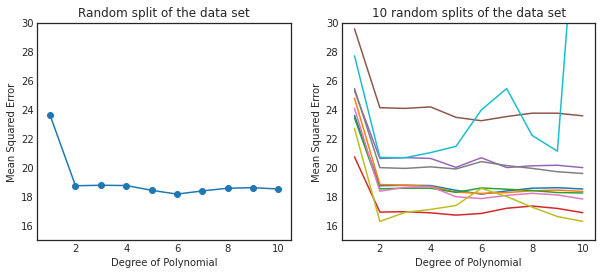

In [2]:
# The Validation Set Approach
df1 = pd.read_csv('../data/Auto.csv', na_values='?').dropna()

t_prop = 0.5
p_order = np.arange(1,11)
r_state = np.arange(0,10)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

regr = skl_lm.LinearRegression()

# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df1.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, df1.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

# Left plot (first split)
ax1.plot(X.T[0],Z.T[0], '-o')
ax1.set_title('Random split of the data set')

# Right plot (all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

> **Figure 5.2.** *Left:* Validation error estimates for a single split into
training and validation data sets. *Right:* The validation method was repeated ten
times, each time using a different random split of the observations into a training
set and a validation set. This illustrates the variability in the estimated test MSE
that results from this approach.

If we repeat the process of randomly splitting the sample set into two parts, we will get a somewhat different estimate for the test MSE. This is illustrated in the right side of the figure. All ten curves indicate that the model with a quadratic term has a dramatically smaller validation set MSE than the model with only a linear term. Furthermore, all ten curves indicate that there is not much benefit in including cubic or higher-order polynomial terms in the model. But it is worth noting that each of the ten curves results in a different test MSE estimate for each of the ten regression models considered. And there is no consensus among the curves as to which model results in the smallest validation set MSE. Based on the variability among these curves, **all that we can conclude with any confidence is that the linear fit is not adequate for this data.**

The validation set approach is conceptually simple and is easy to implement. But it has two potential drawbacks:
    
    1. The validation estimate of the test error rate can be highly variable, depending on precisely which 
    observations are included in the training set and which observations are included in the validation set.
    
    2. In the validation approach, only a subset of the observations are used to fit the model. Since  
    statistical methods tend to perform worse when trained on fewer observations, this suggests that the  
    validation set error rate may tend to overestimate the test error rate for the model fit on the  
    entire data set.
    
In the coming subsections, we will present cross-validation, a refinement of the validation set approach that addresses these two issues.

## Leave-One-Out Cross-Validation
Leave-one-out cross-validation (LOOCV) is closely related to the validation set approach, but it attempts to address that method’s drawbacks.

Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation $(x_1, y_1)$ is used for the validation set, and the remaining observations, $\{ (x_2, y_2), \ldots, (x_n, y_n) \}$ make up the training set.

The statistical learning method is fit on the $n − 1$ training observations, and a prediction $\hat{y_1}$ is made for the excluded observation, using its value $x_1$.  Since $(x_1, y_1)$ was not used in the fitting process, $\text{MSE}_1 = (y_1 - \hat{y}_1)^2$ provides an approximately unbiased estimate for the test error. But even though $\text{MSE}_1$ is unbiased for the test error, it is a poor estimate because it is highly variable, since it is based upon a single observation $(x_1, y_1)$.

We can repeat the procedure by selecting $(x_2 , y_2)$ for the validation data, training the statistical learning procedure on the $n − 1$ observations and computing $\text{MSE}_2 = (y_2 −\hat{y}_2)^2$. Repeating this approach $n$ times produces $n$ squared errors, $\text{MSE}_1, . . . , \text{MSE}_n$.

The LOOCV estimate for the test $\text{MSE}$ is the average of these $n$ test error estimates:

\begin{equation}\label{5.1}
    \text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^{n}\text{MSE}_i 
    \tag{5.1}
\end{equation}

LOOCV has a couple of major advantages over the validation set approach. *First*, it has far less bias. The LOOCV approach tends not to overestimate the test error rate as much as the validation set approach does due to the larger training sample size. *Second*, in contrast to the validation approach which will yield different results when applied repeatedly due to randomness in the training/validation set splits, performing LOOCV multiple times will always yield the same results: there is no randomness in the training/validation set splits.

LOOCV has the potential to be expensive to implement, since the model has to be fit $n$ times. With least squares linear or polynomial regression, an amazing shortcut makes the cost of LOOCV the same as that of a single model fit! The following formula holds:

\begin{equation}\label{5.2}
    \text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^{n} \left( \frac{y_i - \hat{y}_i}{1 - h_i} \right)^2
    \tag{5.2}
\end{equation}

where $\hat{y}_i$ is the $i$th fitted value from the original least squares fit, and $h_i$ is the leverage defined in (3.37). This is like the ordinary $\text{MSE}$, except the $i$th residual is divided by $1 − h_i$. The leverage lies between $1/n$ and $1$, and reflects the amount that an observation influences its own fit. Hence the residuals for high-leverage points are inflated in this formula by exactly the right amount for this equality to hold.

## k-Fold Cross-Validation
This approach involves randomly dividing the set of observations into $k$ groups, or folds, of approximately
equal size. The first fold is treated as a validation set, and the method is fit on the remaining $k − 1$ folds. The mean squared error, $\text{MSE}_1$, is then computed on the observations in the held-out fold. This procedure is repeated $k$ times. This process results in k estimates of the test error, $\text{MSE}_1 , \text{ MSE}_2 , \ldots , \text{ MSE}_k$. The $k$-fold CV estimate is computed by averaging these values,

\begin{equation}\label{5.3}
    \text{CV}_{(k)} = \frac{1}{k} \sum_{i = 1}^{k} \text{MSE}_i  
    \tag{5.3}
\end{equation}

It is not hard to see that LOOCV is a special case of $k$-fold CV in which $k = n$. In practice, one typically performs $k$-fold CV using $k = 5$ or $k = 10$.

What is the advantage of using $k = 5$ or $k = 10$ rather than LOOCV ($k = n$)? The most obvious advantage is computational. There also can be other non-computational advantages to performing 5-fold or 10-fold CV, which involve the bias-variance trade-off.

When we perform cross-validation, our goal might be to determine how well a given statistical learning procedure can be expected to perform on independent data; in this case, the actual estimate of the test $\text{MSE}$ is of interest. But at other times we are interested only in the location of the minimum point in the estimated test $\text{MSE}$ curve. **This is because we might be performing cross-validation on a number of statistical learning
methods, or on a single method using different levels of flexibility, in order to identify the method that results in the lowest test error.** For this purpose, the location of the minimum point in the estimated test MSE curve is
important, but the actual value of the estimated test MSE is not.

## Bias-Variance Trade-Off for k-Fold Cross-Validation
A less obvious but potentially more important advantage of k-fold CV is that it often gives more accurate estimates of the test error rate than does LOOCV. This has to do with a bias-variance trade-off.

It was mentioned that the validation set approach can lead to overestimates of the test error rate, since in this approach the training set used to fit the statistical learning method contains only half the observations of the entire data set. Using this logic, it is not hard to see that LOOCV will give approximately unbiased estimates of the test error, since each training set contains $n − 1$ observations, which is almost as many as the number of observations in the full data set. 

And performing k-fold CV for, say, $k = 5$ or $k = 10$ will lead to an intermediate level of bias, since each training set contains $(k − 1)n/k$ observations—fewer than in the LOOCV approach, but substantially more than in the validation set approach. Therefore, from the perspective of bias reduction, it is clear that LOOCV is to be preferred to k-fold CV.

However, we know that bias is not the only source for concern in an estimating procedure; we must also consider the procedure’s variance. It turns out that LOOCV has higher variance than does k-fold CV with $k < n$.

When we perform LOOCV, we are in effect averaging the outputs of n fitted models, each of which is trained on an almost identical set of observations; therefore, these outputs are highly (positively) correlated with each other. In contrast, when we perform k-fold CV with $k < n$, we are averaging the outputs of $k$ fitted models that are somewhat less correlated with each other, since the overlap between the training sets in each model is smaller.

Since the mean of many highly correlated quantities has higher variance than does the mean of many quantities that are not as highly correlated, the test error estimate resulting from LOOCV tends to have higher variance than does the test error estimate resulting from k-fold CV.


To summarize, there is a bias-variance trade-off associated with the choice of $k$ in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using $k = 5$ or $k = 10$, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.

## Cross-Validation on Classification Problems
In this setting, cross-validation works just as described earlier in this chapter, except that rather than using $\text{MSE}$ to quantify test error, we instead use the number of misclassified observations. For instance, in the  classification setting, the LOOCV error rate takes the form

\begin{equation}\label{5.4}
    \text{CV}_{(n)} = \frac{1}{n} \sum_{i=1}^{n} \text{Err}_i  
    \tag{5.4}
\end{equation}

where $\text{Err}_i = I(y_i \neq \hat{y}_i)$. The k-fold CV error rate and validation set error rates are defined analogously.

The textbook has a high-degree logistic regression example and a KNN example where cross-validation helps determine the appropriate level of flexibility.

---

# The Bootstrap
As a simple example, the **bootstrap** can be used to estimate the standard errors of the coefficients from a linear regression fit. The power of the bootstrap lies in the fact that it can be easily applied to a wide range of
statistical learning methods, including some for which a measure of variability is otherwise difficult to obtain and is not automatically output by statistical software.

### The Investment Example
Suppose that we wish to invest a fixed sum of money in two financial assets that yield returns of $X$ and $Y$, espectively, where $X$ and $Y$ are random quantities. We will invest a fraction $\alpha$ of our money in $X$, and will invest the remaining $1 − \alpha$ in $Y$. Since there is variability associated with the returns on these two assets, we wish to choose $\alpha$ to minimize the total risk, or variance, of our investment. In other words, we want to minimize $\text{Var}(\alpha X + (1 − \alpha)Y )$. One can show that the value that minimizes the risk is given by

\begin{equation}\label{5.6}
    \alpha = \frac{\sigma^2_Y - \sigma_{XY}}{\sigma^2_X + \sigma^2_Y - 2 \sigma_{XY} }
    \tag{5.6}
\end{equation}

where $\sigma^2_X = \text{Var}(X)$, $\sigma^2_Y = \text{Var}(Y)$, $\sigma_{XY} = \text{Cov}(X, Y)$.

In reality, the quantities $\sigma^2_X$, $\sigma^2_Y$, and $\sigma_{XY}$ are unknown. We can compute estimates for these quantities, $\hat{\sigma}^2_X$, $\hat{\sigma}^2_Y$, and $\hat{\sigma}_{XY}$ , using a data set that
contains past measurements for $X$ and $Y$. We can then estimate the value of $\alpha$ that minimizes the variance of our investment using

\begin{equation}\label{5.7}
    \hat{\alpha} = \frac{\hat{\sigma}^2_Y - \hat{\sigma}_{XY}}{\hat{\sigma}^2_X + \hat{\sigma}^2_Y - 2 \hat{\sigma}_{XY} }.
    \tag{5.7}
\end{equation}

We then simulate 100 pairs of returns for the investments $X$ and $Y$. We used these returns to estimate $\sigma_X^2, \sigma_Y^2$, and $\sigma_{XY}$, which we then substituted into (\ref{5.7}) in order to obtain estimates for $\alpha$. The value of $\hat{\alpha}$ resulting from each simulated data set ranges from $0.532$ to $0.657$.

It is natural to wish to quantify the accuracy of our estimate of $\alpha$. To estimate the standard deviation of $\hat{\alpha}$, we repeated the process of simulating 100 paired observations of $X$ and $Y$, and estimating $\alpha$ using (\ref{5.7}), $1,000$ times. We thereby obtained $1,000$ estimates for $\alpha$, which we can call
$\hat{\alpha}_1 , \hat{\alpha}_2 , \ldots , \hat{\alpha}_{1,000}$.

![Alpha Estimates Histograms](figures/5.10.png)
> **Figure 5.10.** *Left:* A histogram of the estimates of α obtained by generating
1,000 simulated data sets from the true population.  
*Center:* A histogram of the estimates of α obtained from 1,000 bootstrap samples from a single data set.  
*Right:* The estimates of α displayed in the left and center panels are shown as boxplots. In each panel, the pink line indicates the true value of α.

The left-hand panel of Figure 5.10 displays a histogram of the resulting estimates. For these simulations the parameters were set to $\sigma_X^2 = 1, \sigma_Y^2$ = 1.25, and $\sigma_{XY} = 0.5$, and so we know that the true value of $\alpha$ is $0.6$. We indicated this value using a solid vertical line on the histogram. The mean over all $1,000$ estimates for $\alpha$ is

\begin{align*}
    \bar{\alpha} = \frac{1}{1,000} \sum^{1,000}_{r=1} \hat{\alpha}_r = 0.5996,
\end{align*}

very close to $\alpha = 0.6$, and the standard deviation of the estimates is

\begin{align*}
    \sqrt{\frac{1}{1,000 - 1} \sum^{1,000}_{r=1} (\hat{\alpha}_r - \bar{\alpha})^2} =0.083
\end{align*}

This gives us a very good idea of the accuracy of $\hat{\alpha}: \text{SE}(\hat{\alpha}) \approx 0.083$. So roughly speaking, for a random sample from the population, we would expect $\hat{\alpha}$ to differ from $\alpha$ by approximately $0.08$, on average.

### The Bootstrap Explained
In practice, the procedure for estimating $\text{SE}(\hat{\alpha})$ outlined above cannot be applied, because for real data we cannot generate new samples from the original population. However, the bootstrap approach allows us
to use a computer to emulate the process of obtaining new sample sets, so that we can estimate the variability of $\hat{\alpha}$ without generating additional samples.

**Rather than repeatedly obtaining independent data sets from the population, we instead obtain distinct data sets by repeatedly sampling observations from the original data set.**

This approach is illustrated in Figure 5.11 on a simple data set, which we call $Z$, that contains only $n = 3$ observations. We randomly select $n$ observations from the data set in order to produce a bootstrap data set, $Z^{*1}$. The sampling is performed with **replacement**, which means that the same observation can occur more than once in the bootstrap data set. Note that if an observation is contained in $Z^{*1}$, then both its $X$ and $Y$ values are included.

![Bootstrap Method](figures/5.11.png)
> **Figure 5.11.** A graphical illustration of the bootstrap approach on a small sample containing n = 3 observations. Each bootstrap data set contains n observations, sampled with replacement from the original data set. Each bootstrap data set is used to obtain an estimate of α.

### Implementing the Bootstrap for $\alpha$
We can use $Z^{∗1}$ to produce a new bootstrap estimate for $\alpha$, which we call $\hat{\alpha}^{∗1}$. This procedure is repeated $B$ times for some large value of $B$, in order to produce $B$ different bootstrap data sets, $Z^{*1}, Z^{*2}, \ldots , Z^{*B}$, and $B$ corresponding $α$ estimates, $\hat{α}^{∗1}, \hat{α}^{∗2} , \ldots , \hat{α}^{∗B}$. We can compute the standard error of these bootstrap estimates using the formula

\begin{equation}\label{5.8}
    \text{SE}_B(\hat{α}) = \sqrt{ \frac{1}{B - 1} \sum^B_{r=1} \left( \hat{α}^{*r} - \frac{1}{B} \sum^B_{r' = 1} \hat{α}^{*r'} \right)^2 } 
    \tag{5.8}
\end{equation}

This serves as an estimate of the standard error of $α̂$ estimated from the original data set.

The bootstrap approach is illustrated in the center panel of Figure 5.10, which displays a histogram of 1,000 bootstrap estimates of $α$, each computed using a distinct bootstrap data set. This panel was constructed on the basis of a single data set, and hence could be created using real data.

In particular the bootstrap estimate SE(α̂) from (\ref{5.8}) is 0.087, very close to the estimate of 0.083 obtained using 1,000 simulated data sets. This indicates that the bootstrap approach can be used to effectively estimate the variability associated with α̂ without access to the population data.

---

# End Chapter